# **MDANCE**
**Molecular Dynamics Analysis with N-ary Clustering Ensembles (MDANCE)** is a flexible n-ary clustering package that provides a set of tools for clustering Molecular Dynamics trajectories. The package is designed to be modular and extensible, allowing for the addition of new clustering algorithms and similarity metrics. You can find more information here: https://mdance.readthedocs.io/

Notebook by [Pablo Ricardo Arantes](https://pablo-arantes.github.io/)

# **Overview**
This clustering notebook is meant for Molecular Dynamics datasets. We will use the k-Means N-Ary Natural Initiation (NANI) algorithm to select initial centroids on k-Means clustering. NANI is an extension of the k-Means++ algorithm. NANI stratifies the data to high density region and perform diversity selection on top of the it to select the initial centroids. This is a deterministic algorithm that will always select the same initial centroids for the same dataset and improve on k-means++ by reducing the number of iterations required to converge and improve the clustering quality.

For more information on the NANI algorithm, please refer to the NANI paper: https://doi.org/10.1021/acs.jctc.4c00308.

In [ ]:
#@title **Install MDANCE**
#@markdown It will be fast. ;-)
%%capture
import sys
import tarfile
import os
import subprocess
import sys

commands = [
    "pip install mdance",
]

for cmd in commands:
    subprocess.run(cmd, shell=True)

In [ ]:
# @title ### **Preprocessing of Molecular Dynamics Data**
#@markdown MDANCE provides a set of tools to preprocess molecular dynamics trajectories before clustering. This includes reading the trajectories, normalizing them, and aligning them. The present cell reads a trajectory and save it as a numpy array.

import numpy as np

from mdance import data
from mdance.inputs.preprocess import gen_traj_numpy

#@markdown **Before to start, don't forget to upload your topology and trajectory here at Google Colab.**


#@markdown Enter the path for the trajectory file (e.g., protG_short):
trajectory_file =  'protG_short' #@param {type:"string"}
input_format_trajectory = "dcd" #@param ["pdb", "dcd", "nc", "xtc", "gro", "trr"]


#@markdown Enter the path for the topology file (e.g., protG_short):

topology_file = 'protG_short' #@param {type:"string"}
input_format_topology = "pdb" #@param ["pdb", "gro", "top", "tpr", "prmtop", "parm7", "psf"]


#@markdown The atom selection used for clustering that must be compatible with the [MDAnalysis Atom Selections Language](https://userguide.mdanalysis.org/stable/selections.html).


selection = 'name CA' #@param {type:"string"}
output_file_name = 'protG_short' #@param {type:"string"}

input_traj = f'{trajectory_file}.{input_format_trajectory}'
input_top = f'{topology_file}.{input_format_topology}'
output_base_name = output_file_name
atomSelection = selection

traj_numpy = gen_traj_numpy(input_top, input_traj, atomSelection)
output_name = output_base_name + '.npy'
np.save(output_name, traj_numpy)

/usr/local/lib/python3.10/dist-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


Number of atoms in trajectory: 5162
Number of frames in trajectory: 1000
Number of atoms in selection: 317


In [ ]:
# @title ### **NANI Screening**
#@markdown  This cell will run NANI for a range of clusters and calculate cluster quality metrics. For the best result, we recommend running NANI over a wide range of number of clusters. Specified the following NANI parameters:
import os

import numpy as np

from mdance.cluster.nani import KmeansNANI, compute_scores
from mdance import data
from mdance.tools.bts import extended_comparison

#@markdown **N_atoms** is the number of atoms used in the clustering.

N_atoms = "317" #@param {type:"string"}
#@markdown **sieve** takes every sieve-th frame from the trajectory for analysis.

sieve = "1" #@param {type:"string"}

#@markdown **start_n_clusters** is the starting number for screening. This number must be greater than 2.

start_n_clusters = "2" #@param {type:"string"}

#@markdown **end_n_clusters** is the ending number for screening.

end_n_clusters = "30" #@param {type:"string"}


# System info
input_traj_numpy = output_name
N_atoms = int(N_atoms)
sieve = int(sieve)

# NANI parameters
output_dir = f'outputs_{output_file_name}'
init_types = ['comp_sim']                                           # Must be a list
metric = 'MSD'
start_n_clusters = int(start_n_clusters)                                                # At least 2 clusters
end_n_clusters = int(end_n_clusters)                                                 # Maximum number of clusters


if __name__ == '__main__':
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    traj_numpy = np.load(input_traj_numpy)[::sieve]
    for init_type in init_types:
        if init_type in ['k-means++', 'random', 'vanilla_kmeans++']:
            percentage = ''

        # `comp_sim` and `div_select` are ran only once to get the initiators
        elif init_type in ['comp_sim', 'div_select']:
            percentage = 10
            mod = KmeansNANI(data=traj_numpy, n_clusters=end_n_clusters, metric=metric,
                             N_atoms=N_atoms, init_type=init_type, percentage=percentage)
            initiators = mod.initiate_kmeans()

        all_scores = []
        for i in range(start_n_clusters, end_n_clusters+1):
            total = 0

            # Run k-means clustering
            if init_type in ['comp_sim', 'div_select']:
                mod = KmeansNANI(data=traj_numpy, n_clusters=i, metric=metric,
                                 N_atoms=N_atoms, init_type=init_type, percentage=percentage)
                labels, centers, n_iter = mod.kmeans_clustering(initiators[:i])
            elif init_type in ['k-means++', 'random']:
                mod = KmeansNANI(data=traj_numpy, n_clusters=i, metric=metric,
                                 N_atoms=N_atoms, init_type=init_type)
                labels, centers, n_iter = mod.kmeans_clustering(initiators=init_type)
            elif init_type == 'vanilla_kmeans++':
                mod = KmeansNANI(data=traj_numpy, n_clusters=i, metric=metric,
                                 N_atoms=N_atoms, init_type=init_type)
                initiators = mod.initiate_kmeans()
                labels, centers, n_iter = mod.kmeans_clustering(initiators=initiators)


            # Compute scores
            ch_score, db_score = compute_scores(data=traj_numpy, labels=labels)

            # Calculate MSD for each cluster
            dict = {}
            for j in range(i):
                dict[j] = np.where(labels == j)[0]
                dict[j] = traj_numpy[dict[j]]
            for key in dict:
                msd = extended_comparison(np.array(dict[key]), traj_numpy_type='full',
                                          metric=metric, N_atoms=N_atoms)
                total += msd
            all_scores.append((i, n_iter, ch_score, db_score, total/i))

        all_scores = np.array(all_scores)
        header = f'init_type: {init_type}, percentage: {percentage}, metric: {metric}, sieve: {sieve}\n'
        header += 'Number of clusters, Number of iterations, Calinski-Harabasz score, Davies-Bouldin score, Average MSD'
        np.savetxt(f'{output_dir}/{output_file_name}_summary.csv', all_scores,
                   delimiter=',', header=header, fmt='%s')

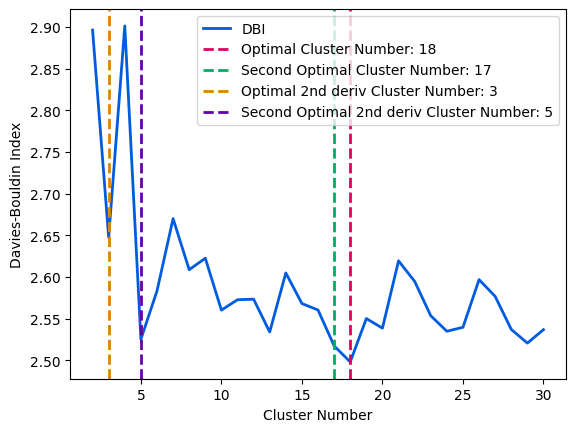

In [ ]:
# @title ### **Cluster Analysis**
#@markdown The output from last cell (NANI screening) will be used to plot the optimal number of clusters.

#@markdown The function below will plot the Davies-Bouldin index and the optimal number of clusters.
#@markdown The optimal number of clusters is determined by the minimum Davies-Bouldin index or the minimum of the second derivative of the Davies-Bouldin index.


import matplotlib.pyplot as plt
import numpy as np

scores_csvs = [f'{output_dir}/{output_file_name}_summary.csv']

def plot_scores(scores_csv):
    """Plot the Davies-Bouldin index and the optimal number of clusters.

    Parameters
    ----------
    scores_csv : str
        The path to the csv file that contains the screening

    Returns
    -------
    file
        A png file that contains the plot of the Davies-Bouldin index and the optimal number of clusters
    """
    base_name = scores_csv.split('\\')[-1].split('.csv')[0]
    n_clus, db = np.loadtxt(scores_csv, unpack=True, delimiter=',', usecols=(0, 3))

    # Plot the Davies-Bouldin index and the optimal number of clusters
    all_indices = np.argsort(db)
    min_db_index = all_indices[0]
    min_db = n_clus[min_db_index]
    all_indices = np.delete(all_indices, 0)
    second_min_index = all_indices[0]
    second_min_db = n_clus[second_min_index]

    fig, ax = plt.subplots()
    ax.plot(n_clus, db, color='#005cde', label='DBI', linewidth=2)
    ax.set_xlabel('Cluster Number')
    ax.set_ylabel('Davies-Bouldin Index')
    ax.axvline(x=min_db, color='#de005c', linestyle='--', label=f'Optimal Cluster Number: {int(min_db)}', linewidth=2)
    ax.axvline(x=second_min_db, color='#00ab64', linestyle='--', label=f'Second Optimal Cluster Number: {int(second_min_db)}', linewidth=2)

    # Calculate the second derivative (before + after - 2*current)
    arr = db
    x = n_clus[1:-1]
    result = []
    for start_index, n_clusters in zip(range(1, len(arr) - 1), x):
        temp = arr[start_index + 1] + arr[start_index - 1] - (2 * arr[start_index])
        if arr[start_index] <= arr[start_index - 1] and arr[start_index] <= arr[start_index + 1]:
            result.append((n_clusters, temp))
    result = np.array(result)
    if len(result) == 0:
        print('No maxima found')
    elif len(result) >= 1:
        sorted_indices = np.argsort(result[:, 1])[::-1]
        sorted_result = result[sorted_indices]
        min_x = sorted_result[0][0]
        ax.axvline(x=min_x, color='#de8200', linestyle='--', label=f'Optimal 2nd deriv Cluster Number: {int(min_x)}', linewidth=2)
        if len(sorted_result) >= 2:
            sec_min_x = sorted_result[1][0]
            ax.axvline(x=sec_min_x, color='#6400ab', linestyle='--', label=f'Second Optimal 2nd deriv Cluster Number: {int(sec_min_x)}', linewidth=2)

    ax.legend(fontsize=10)
    plt.savefig(f'outputs_{output_file_name}/{output_file_name}_summary.png', format='png', dpi=300)
    plt.show()

if __name__ == '__main__':
    for scores_csv in scores_csvs:
        plot_scores(scores_csv)

In [ ]:
# @title ### **Cluster Assignment**
#@markdown This cell will assign labels to the clusters for k-means clustering using the initialization methods. The following parameters need to be specified:

import os

import numpy as np

from mdance.cluster.nani import KmeansNANI
from mdance import data
from mdance.tools.bts import extended_comparison, calculate_medoid


#@markdown **N_atoms** is the number of atoms used in the clustering.
N_atoms = "317" #@param {type:"string"}
#@markdown **sieve** takes every sieveth frame from the trajectory for analysis.
sieve = "1" #@param {type:"string"}
#@markdown **n_clusters** is the number of clusters for labeling.
n_clusters = "18" #@param {type:"string"}
#@markdown **n_structures** is the number of frames to extract from each cluster.
n_structures = "20" #@param {type:"string"}



# System info - EDIT THESE
input_traj_numpy = output_name
N_atoms = int(N_atoms)
sieve = int(sieve)

# K-means params - EDIT THESE
n_clusters = int(n_clusters)
init_type = 'comp_sim'                                              # Default
metric = 'MSD'                                                      # Default
n_structures = int(n_structures)                                                   # Default
output_dir = f'outputs_{output_file_name}'                                              # Default


if __name__ == '__main__':
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    traj_numpy = np.load(input_traj_numpy)[::sieve]
    mod = KmeansNANI(data=traj_numpy, n_clusters=n_clusters, N_atoms=N_atoms, init_type=init_type,
                     metric=metric, percentage=10)
    labels, centers, n_iter = mod.execute_kmeans_all()
    sort_labels_by_size = np.argsort(np.bincount(labels))[::-1]
    labels = np.array([np.where(sort_labels_by_size == i)[0][0] for i in labels])
    best_frames = []
    cluster_msd = []

    # Save best frames indices for each cluster
    for i, label in enumerate(np.unique(labels)):
        cluster = np.where(labels == label)[0]
        if len(cluster) > 1:
            medoid_index = calculate_medoid(traj_numpy[cluster], metric=metric, N_atoms=N_atoms)
            medoid = traj_numpy[cluster][medoid_index]
            msd_to_medoid = []
            for j, frame in enumerate(traj_numpy[cluster]):
                msd_to_medoid.append((j, extended_comparison(
                    np.array([frame, medoid]), data_type='full', metric=metric, N_atoms=N_atoms)))
            msd_to_medoid = np.array(msd_to_medoid)
            sorted_indices = np.argsort(msd_to_medoid[:, 1])
            best_n_structures = traj_numpy[cluster][sorted_indices[:n_structures]]
            best_frames.append(best_n_structures)

    best_frames_indices = []
    for i, frame in enumerate(traj_numpy):
        i = i * sieve
        for j, cluster in enumerate(best_frames):
            if np.any(np.all(cluster == frame, axis=1)):
                best_frames_indices.append((i, j))
    best_frames_indices = np.array(best_frames_indices)
    best_frames_indices = best_frames_indices[best_frames_indices[:, 1].argsort()]
    np.savetxt(f'{output_dir}/best_frames_indices_{n_clusters}.csv', best_frames_indices, delimiter=',', fmt='%s',
               header=f'Numer of clusters,{n_clusters}\nFrame Index,Cluster Index')

    # Save cluster labels
    with open(f'{output_dir}/labels_{n_clusters}.csv', 'w') as f:
        f.write(f'# init_type: {init_type}, Number of clusters: {n_clusters}\n')
        f.write('# Frame Index, Cluster Index\n')
        for i, row in enumerate(labels):
            f.write(f'{i * sieve},{row}\n')

    # Calculate population of each cluster
    with open(f'{output_dir}/summary_{n_clusters}.csv', 'w') as f:
        f.write(f'# Number of clusters, {n_clusters}\n')
        f.write('# Cluster Index, Fraction out of total pixels\n')
        for i, row in enumerate(np.bincount(labels)):
            f.write(f'{i},{row/len(labels)}\n')

In [ ]:
# @title ### **Extract frames for each cluster**
#@markdown MDANCE provides a set of tools to postprocess the clustering results. This cell will write out trajectories for each cluster.

import MDAnalysis as mda
import numpy as np

from mdance import data

output_format = "dcd" #@param ["dcd", "nc", "xtc", "gro", "trr"]

input_traj = f'{trajectory_file}.{input_format_trajectory}'
input_top = f'{topology_file}.{input_format_topology}'

u = mda.Universe(input_top, input_traj)
print(f'Number of atoms in the trajectory: {u.atoms.n_atoms}')

cluster_assignment = f'{output_dir}/best_frames_indices_{n_clusters}.csv'

x, y = np.loadtxt(cluster_assignment, delimiter=',', skiprows=2, dtype=int, unpack=True)

# get x value in a list for every unique y value
frames = [x[y == i] for i in np.unique(y)]

for i, frame in enumerate(frames):
   # write trajectory with only the selected frames in frames[i]
    with mda.Writer(f'{output_dir}/best_frames_{i}.{output_format}', u.atoms.n_atoms) as W:
        for ts in u.trajectory[frame]:
            W.write(u.atoms)

Number of atoms in the trajectory: 5162


In [ ]:
#@title **Download your results**
from google.colab import files
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

if os.path.exists(f"results_MDANCE_{output_file_name}.zip"):
  os.remove(f"results_MDANCE_{output_file_name}.zip")
else:
  pass

subprocess.run(f"zip -FSr results_MDANCE_{output_file_name}.zip {output_dir}" , shell=True)

files.download(f"results_MDANCE_{output_file_name}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>